In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from datetime import datetime


from utils import concat_dfs, substituir_cod_municipio, criar_dataset_completo

%cd ..


/home/diego/Desktop/monografia


In [2]:
df_all = criar_dataset_completo()

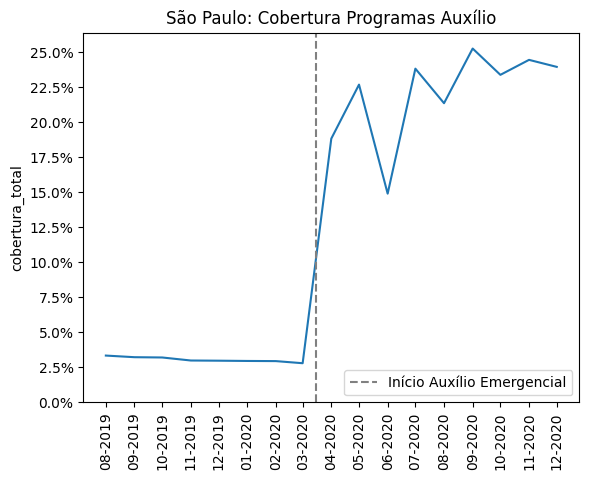

In [3]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="cobertura_total")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
ax.yaxis.set_major_formatter(lambda x, y: "{:1.1f}%".format(x * 100))
plt.yticks(np.arange(0, max(data["cobertura_total"]), 0.025))
plt.xticks(rotation=90)
# plt.ylabel("Soma Benefícios (R$)")
plt.xlabel("")
plt.axvline(
    datetime(2020, 3, 15),
    linestyle="dashed",
    label="Início Auxílio Emergencial",
    color="grey",
)
plt.title("São Paulo: Cobertura Programas Auxílio")
plt.legend()
plt.show()


In [4]:
data[data['date'] == '2020-11-01']

,municipio_ibge,beneficiarios_bolsa_familia,date,beneficiarios_auxilio_emergencial,ano,municipio_ibge6,populacao,nome_municipio,total_ambulatoriais_psico,total_ambulatoriais_geral,...,ambulatoriais_por_100,ambulatoriais_jovens_por_100,t_esquizofrenicos_por_100,t_psicoticos_por_100,t_depressao_por_100,t_ansiedade_por_100,t_estresse_por_100,t_comportamentais_por_100,abusos_substancias_por_100,total_transtornos_por_100
159521,3550308.0,436096.0,2020-11-01,2576090.0,2020.0,355030,12325232.0,SAO PAULO,76469.0,10520396.0,...,0.620426,0.204621,0.001963,0.001574,0.000892,0.000065,0.000073,0.000016,0.003002,0.007586


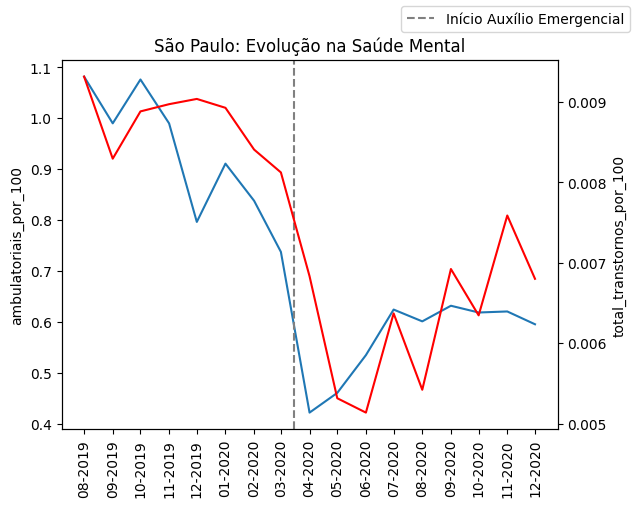

In [5]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="ambulatoriais_por_100")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
plt.xticks(rotation=90)
plt.xlabel("")
plt.axvline(
    datetime(2020, 3, 15),
    linestyle="dashed",
    label="Início Auxílio Emergencial",
    color="grey",
)
ax2 = ax.twinx()
sns.lineplot(data=data, x="date", y="total_transtornos_por_100", ax=ax2, color = 'red')
plt.title("São Paulo: Evolução na Saúde Mental")
ax.figure.legend()
plt.show()


### Agregando os municípios e vendo quebra dos que tiveram maior grau de cobertura

2019-07-01 00:00:00
2020-12-01 00:00:00


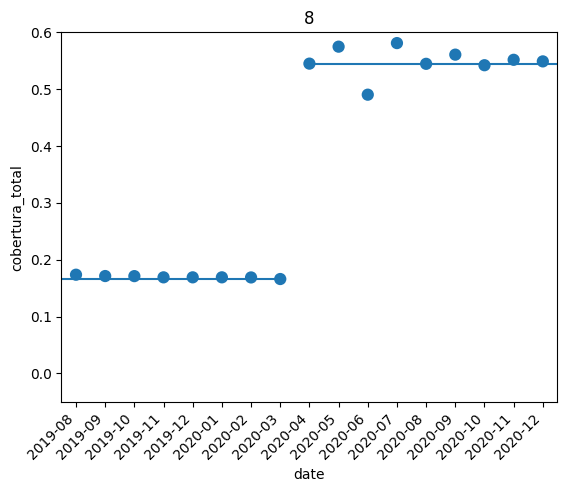

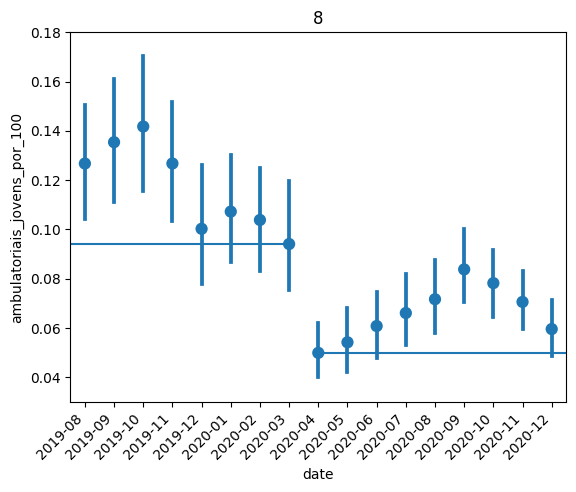

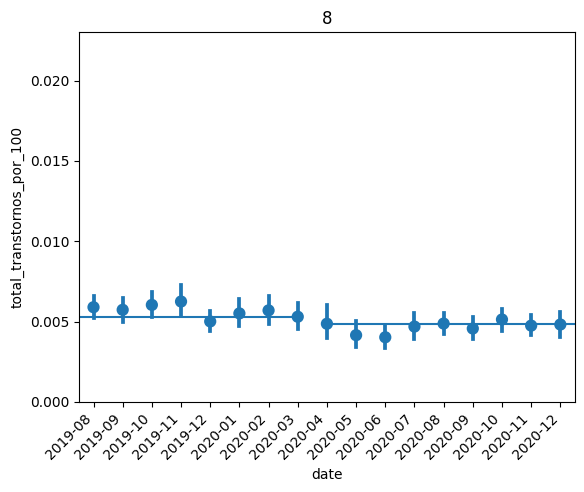

In [13]:
for n_meses in [8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_total", "ambulatoriais_jovens_por_100", "total_transtornos_por_100"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["cobertura_total_y"] - df_antes_depois["cobertura_total_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    maior_percentil = df_antes_depois[
        df_antes_depois["percentil"] == df_antes_depois["percentil"].max()
    ]["municipio_ibge"].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(maior_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (
        time_series_data["date"] <= end_date
    )

    time_series_data = time_series_data[date_filter]

    h_line_value_before = time_series_data[time_series_data['date'] == '2020-03-01']['cobertura_total'].mean()
    h_line_value_after = time_series_data[time_series_data['date'] == '2020-04-01']['cobertura_total'].mean()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="cobertura_total",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    ax.set_ylim([-0.05, 0.6])
    ax.axhline(h_line_value_before, xmax=0.45)
    ax.axhline(h_line_value_after, xmin=0.5)
    plt.title(f"{n_meses}")
    plt.show()

    h_line_value_before = time_series_data[time_series_data['date'] == '2020-03-01']['ambulatoriais_jovens_por_100'].mean()
    h_line_value_after = time_series_data[time_series_data['date'] == '2020-04-01']['ambulatoriais_jovens_por_100'].mean()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="ambulatoriais_jovens_por_100",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    ax.axhline(h_line_value_before, xmax=0.45)
    ax.axhline(h_line_value_after, xmin=0.5)
    ax.set_ylim([0.03, 0.18])
    plt.title(f"{n_meses}")
    plt.show()

    h_line_value_before = time_series_data[time_series_data['date'] == '2020-03-01']['total_transtornos_por_100'].mean()
    h_line_value_after = time_series_data[time_series_data['date'] == '2020-04-01']['total_transtornos_por_100'].mean()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="total_transtornos_por_100",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    ax.axhline(h_line_value_before, xmax=0.45)
    ax.axhline(h_line_value_after, xmin=0.5)
    plt.title(f"{n_meses}")
    ax.set_ylim([0, 0.023])
    plt.show()

### Agregando os municípios e vendo quebra dos que tiveram menor grau de cobertura

2019-07-01 00:00:00
2020-12-01 00:00:00


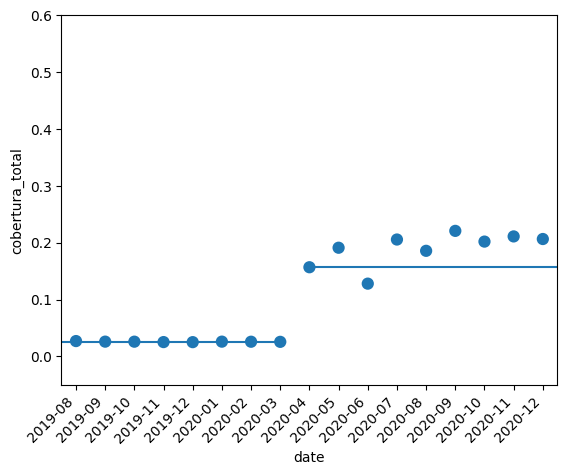

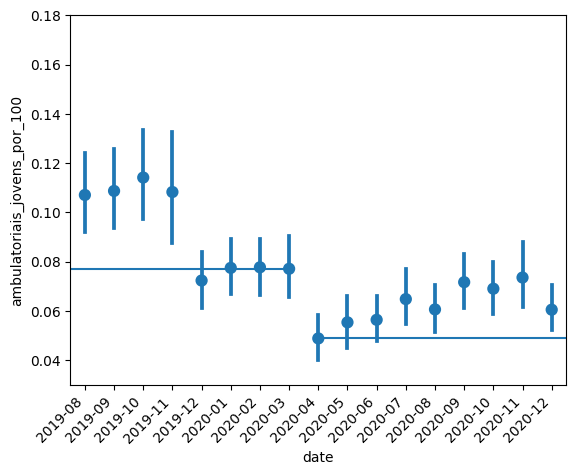

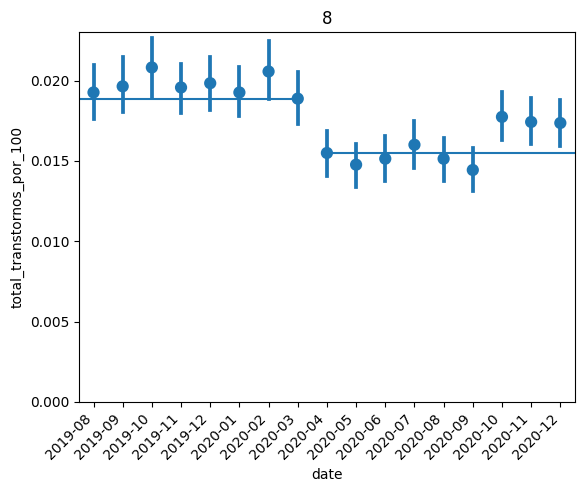

In [12]:
for n_meses in [8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_total", "ambulatoriais_jovens_por_100", "total_transtornos_por_100"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["cobertura_total_y"] - df_antes_depois["cobertura_total_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    menor_percentil = df_antes_depois[
        df_antes_depois["percentil"] == df_antes_depois["percentil"].min()
    ]["municipio_ibge"].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(menor_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (
        time_series_data["date"] <= end_date
    )

    time_series_data = time_series_data[date_filter]

    h_line_value_before = time_series_data[time_series_data['date'] == '2020-03-01']['cobertura_total'].mean()
    h_line_value_after = time_series_data[time_series_data['date'] == '2020-04-01']['cobertura_total'].mean()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="cobertura_total",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    ax.set_ylim([-0.05, 0.6])
    ax.axhline(h_line_value_before, xmax=0.45)
    ax.axhline(h_line_value_after, xmin=0.5)
    plt.show()
    
    h_line_value_before = time_series_data[time_series_data['date'] == '2020-03-01']['ambulatoriais_jovens_por_100'].mean()
    h_line_value_after = time_series_data[time_series_data['date'] == '2020-04-01']['ambulatoriais_jovens_por_100'].mean()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="ambulatoriais_jovens_por_100",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    ax.axhline(h_line_value_before, xmax=0.45)
    ax.axhline(h_line_value_after, xmin=0.5)
    ax.set_ylim([0.03, 0.18])
    plt.show()

    h_line_value_before = time_series_data[time_series_data['date'] == '2020-03-01']['total_transtornos_por_100'].mean()
    h_line_value_after = time_series_data[time_series_data['date'] == '2020-04-01']['total_transtornos_por_100'].mean()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="total_transtornos_por_100",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    ax.axhline(h_line_value_before, xmax=0.45)
    ax.axhline(h_line_value_after, xmin=0.5)
    # ax.set_ylim([0.04, 0.18])
    plt.title(f"{n_meses}")
    ax.set_ylim([0, 0.023])
    plt.show()